In [1]:
!pip install gymnasium

--

Environment Description

CartPole-v1 : https://gymnasium.farama.org/environments/classic_control/cart_pole/

Acrobot-v1 : https://gymnasium.farama.org/environments/classic_control/acrobot/

MountainCar-v0 : https://gymnasium.farama.org/environments/classic_control/mountain_car/

--

In [2]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Keep randomness the same 

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)



---



## 1. DQN Implemetation

In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # input  : (b_size, state_dim)
        # output : (b_size, action_dim)
        self.hidden_dim = 256
        self.layer1 = nn.Linear(state_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, action_dim)
        

    def forward(self, s):
        #
        s_x = F.leaky_relu(self.layer1(s))
        q = self.layer2(s_x)

        return q

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        # Do not modify these hyper-parameters
        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        # You can modify this depending on environments.
        self.epsilon_decay_rate = 0.95 # decay rate

        # Define and initialize your networks and optimizer
        self.q_network =  QNetwork(self.state_size, self.action_size).to(device)
        self.target_network =  QNetwork(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion =  nn.MSELoss() 


    def update_target_network(self):
        # implement target Q network update function
        self.target_network.load_state_dict(self.q_network.state_dict())



    def get_action(self, state, use_epsilon_greedy=True):

        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)

        if use_epsilon_greedy:
            # implement epsilon greedy policy given state
            if random.random() < self.epsilon:
                
                action = random.randrange(self.action_size)
            else:
                
                with torch.no_grad():
                    action = self.q_network(state).max(1).indices.item()
        else:
            # implement greedy policy given state
            # this greedy policy is used for evaluation
            with torch.no_grad():
                    action = self.q_network(state).max(1).indices.item()

        return action

    def append_sample(self, state, action, reward, next_state, done):
        # implement storing function given (s,a,r,s',done) into the replay memory.
        self.memory.append((state, action, reward, next_state, done)) 

    def get_samples(self, n):
        # implement transition random sampling function from the replay memory,
        # and make the transiton to batch.

        transition_batch = random.sample(self.memory,n)

        states, actions, rewards, next_states, dones = zip(*transition_batch)

        s_batch = torch.tensor(states, dtype=torch.float32, device=self.device)
        a_batch = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        r_batch = torch.tensor(rewards, device=self.device).unsqueeze(1)
        s_next_batch = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        done_batch = torch.tensor(dones, dtype=torch.bool, device=self.device)

        # i.e.) s_batch : (batch_size, state_dim)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch

    def epsilon_decay(self):
        # implement epsilon decaying function
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay_rate)

    def train(self):
        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)

        # implement DQN training function.
        # You can return any statistics you want to check and analize the training.  (i.e. loss, q values, target q values, ... etc)

        
        q_values = self.q_network(s_batch).gather(1,a_batch)
        
        next_state_values = torch.zeros(self.batch_size, 1, device=self.device)

        with torch.no_grad():
            next_state_values[~done_batch] = self.target_network(s_next_batch[~done_batch]).max(1).values.unsqueeze(1) 
            
        expected_q_values = (next_state_values * self.discount_factor) + r_batch
        loss = self.criterion(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return None



In [6]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [7]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "MountainCar-v0"

In [8]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:2, action_size:3, max_episode_steps:200, device:cuda 

Epoch:0, Episode_score:-200.0, Episode_steps:200, epsilon:0.95
Epoch:10, Episode_score:-200.0, Episode_steps:200, epsilon:0.5688000922764596
Epoch:20, Episode_score:-200.0, Episode_steps:200, epsilon:0.34056162628811465
Epoch:30, Episode_score:-200.0, Episode_steps:200, epsilon:0.20390682574579033
Epoch:40, Episode_score:-200.0, Episode_steps:200, epsilon:0.12208654873684793
Epoch:50, Episode_score:-200.0, Episode_steps:200, epsilon:0.07309772651287748
Epoch:60, Episode_score:-200.0, Episode_steps:200, epsilon:0.04376630903760433
Epoch:70, Episode_score:-200.0, Episode_steps:200, epsilon:0.02620450591493621
Epoch:80, Episode_score:-200.0, Episode_steps:200, epsilon:0.015689605665762895
Epoch:90, Episode_score:-200.0, Episode_steps:200, epsilon:0.009393946474176
Epoch:100, Episode_score:-200.0, Episode_steps:200, epsilon:0.0056245027593172965
Epoch:110, Episode_score:-200.0, Episode_steps:200, epsilon:0.003367597566851453

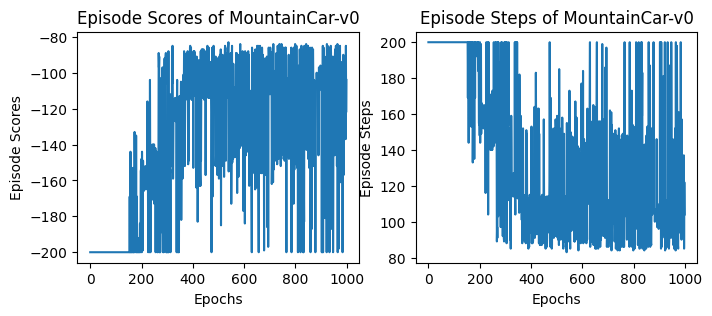

In [9]:
# This cell provides basic evaluation score graph. You can add more plots.

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()

Computing average reward score every 100 episodes

In [10]:
episode_scores = torch.Tensor(episode_scores_list)

print("Intervals of 100")
start=0
for i in range(10):
    end = (i+1)*100
    average = torch.mean(episode_scores[start:end]).item()
    print(" Average reward interval {} ~ {} = ".format(start,end), round(average))
    start = end

print("\n")
print("Long intervals")
average = torch.mean(episode_scores[300:700]).item()
print(" Average reward interval {} ~ {} = ".format(300,700), round(average))
average = torch.mean(episode_scores[500:1000]).item()
print(" Average reward interval {} ~ {} = ".format(500,1000), round(average))

Intervals of 100
 Average reward interval 0 ~ 100 =  -200
 Average reward interval 100 ~ 200 =  -192
 Average reward interval 200 ~ 300 =  -156
 Average reward interval 300 ~ 400 =  -126
 Average reward interval 400 ~ 500 =  -113
 Average reward interval 500 ~ 600 =  -120
 Average reward interval 600 ~ 700 =  -127
 Average reward interval 700 ~ 800 =  -115
 Average reward interval 800 ~ 900 =  -119
 Average reward interval 900 ~ 1000 =  -119


Long intervals
 Average reward interval 300 ~ 700 =  -122
 Average reward interval 500 ~ 1000 =  -120


Computing average steps every 100 episodes

In [11]:
episode_step = torch.Tensor(episode_steps_list)

print("Intervals of 100")
start=0
for i in range(10):
    end = (i+1)*100
    average = torch.mean(episode_step[start:end]).item()
    print(" Average steps interval {} ~ {} = ".format(start,end), round(average))
    start = end

print("\n")
print("Long intervals")
average = torch.mean(episode_step[300:700]).item()
print(" Average steps interval {} ~ {} = ".format(300,700), round(average))
average = torch.mean(episode_step[500:1000]).item()
print(" Average steps interval {} ~ {} = ".format(500,1000), round(average))

Intervals of 100
 Average steps interval 0 ~ 100 =  200
 Average steps interval 100 ~ 200 =  192
 Average steps interval 200 ~ 300 =  156
 Average steps interval 300 ~ 400 =  126
 Average steps interval 400 ~ 500 =  113
 Average steps interval 500 ~ 600 =  120
 Average steps interval 600 ~ 700 =  127
 Average steps interval 700 ~ 800 =  115
 Average steps interval 800 ~ 900 =  119
 Average steps interval 900 ~ 1000 =  119


Long intervals
 Average steps interval 300 ~ 700 =  122
 Average steps interval 500 ~ 1000 =  120




---



## 2. Double DQN implemantation

In [12]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # input  : (b_size, state_dim)
        # output : (b_size, action_dim)
        self.hidden_dim = 256
        self.layer1 = nn.Linear(state_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, action_dim)


    def forward(self, s):
        #
        s_x = F.leaky_relu(self.layer1(s))
        q = self.layer2(s_x)

        return q

In [13]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        # Do not modify these hyper-parameters
        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        # You can modify this depending on environments.
        self.epsilon_decay_rate = 0.95  # decay rate

        # Define and initialize your networks and optimizer
        self.q_network =  QNetwork(self.state_size, self.action_size).to(device)
        self.target_network =  QNetwork(self.state_size, self.action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion =  nn.MSELoss()



    def update_target_network(self):
        # implement target Q network update function
        self.target_network.load_state_dict(self.q_network.state_dict())


    def get_action(self, state, use_epsilon_greedy=True):

        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)

        if use_epsilon_greedy:
            # implement epsilon greedy policy given state

            if random.random() < self.epsilon:
                
                action = random.randrange(self.action_size)
            else:
                
                with torch.no_grad():
                    action = self.q_network(state).max(1).indices.item()

        else:
            # implement greedy policy given state
            # this greedy policy is used for evaluation
            with torch.no_grad():
                    action = self.q_network(state).max(1).indices.item()

        return action

    def append_sample(self, state, action, reward, next_state, done):
        # implement storing function given (s,a,r,s',done) into the replay memory.
        self.memory.append((state, action, reward, next_state, done)) 

    def get_samples(self, n):
        # implement transition random sampling function from the replay memory,
        # and make the transiton to batch.
        transition_batch = random.sample(self.memory,n)

        states, actions, rewards, next_states, dones = zip(*transition_batch)

        s_batch = torch.tensor(states, dtype=torch.float32, device=self.device)
        a_batch = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        r_batch = torch.tensor(rewards, device=self.device).unsqueeze(1)
        s_next_batch = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        done_batch = torch.tensor(dones, dtype=torch.bool, device=self.device)

        # i.e.) s_batch : (batch_size, state_dim)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch

    def epsilon_decay(self):
        # implement epsilon decaying function that
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay_rate)

    def train(self):
        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)

        # implement Double DQN training function.
        # You can return any statistics you want to check and analize the training. (i.e. loss, q values, target q values, ... etc)
        q_values = self.q_network(s_batch).gather(1,a_batch)

        ###############################################################
        # Q network chooses the best action for next states
        next_actions = self.q_network(s_next_batch).max(1).indices.detach().unsqueeze(1)  

        # Target network estimates Q values of the selected actions
        next_state_values = torch.zeros(self.batch_size, 1, device=self.device)  
        with torch.no_grad():
            next_state_values[~done_batch] = self.target_network(s_next_batch[~done_batch]).gather(1, next_actions[~done_batch])

        ###############################################################
        
        expected_q_values = (next_state_values * self.discount_factor) + r_batch
        loss = self.criterion(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return None



In [14]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [15]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "MountainCar-v0"

In [16]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DoubleDQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:2, action_size:3, max_episode_steps:200, device:cuda 

Epoch:0, Episode_score:-200.0, Episode_steps:200, epsilon:0.95
Epoch:10, Episode_score:-200.0, Episode_steps:200, epsilon:0.5688000922764596
Epoch:20, Episode_score:-200.0, Episode_steps:200, epsilon:0.34056162628811465
Epoch:30, Episode_score:-200.0, Episode_steps:200, epsilon:0.20390682574579033
Epoch:40, Episode_score:-200.0, Episode_steps:200, epsilon:0.12208654873684793
Epoch:50, Episode_score:-200.0, Episode_steps:200, epsilon:0.07309772651287748
Epoch:60, Episode_score:-156.0, Episode_steps:156, epsilon:0.04376630903760433
Epoch:70, Episode_score:-200.0, Episode_steps:200, epsilon:0.02620450591493621
Epoch:80, Episode_score:-200.0, Episode_steps:200, epsilon:0.015689605665762895
Epoch:90, Episode_score:-200.0, Episode_steps:200, epsilon:0.009393946474176
Epoch:100, Episode_score:-200.0, Episode_steps:200, epsilon:0.0056245027593172965
Epoch:110, Episode_score:-184.0, Episode_steps:184, epsilon:0.003367597566851453

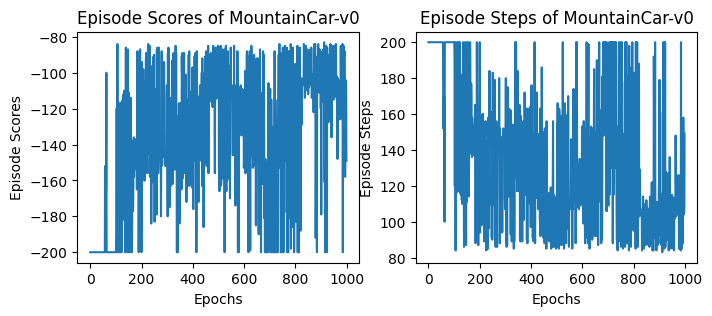

In [17]:
# This cell provides basic evaluation score graph. You can add more plots.

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()

Computing average reward score every 100 episodes

In [18]:
episode_scores = torch.Tensor(episode_scores_list)

print("Intervals of 100")
start=0
for i in range(10):
    end = (i+1)*100
    average = torch.mean(episode_scores[start:end]).item()
    print(" Average reward interval {} ~ {} = ".format(start,end), round(average))
    start = end

print("\n")
print("Long intervals")
average = torch.mean(episode_scores[300:700]).item()
print(" Average reward interval {} ~ {} = ".format(300,700), round(average))
average = torch.mean(episode_scores[500:1000]).item()
print(" Average reward interval {} ~ {} = ".format(500,1000), round(average))

Intervals of 100
 Average reward interval 0 ~ 100 =  -197
 Average reward interval 100 ~ 200 =  -151
 Average reward interval 200 ~ 300 =  -135
 Average reward interval 300 ~ 400 =  -136
 Average reward interval 400 ~ 500 =  -121
 Average reward interval 500 ~ 600 =  -124
 Average reward interval 600 ~ 700 =  -143
 Average reward interval 700 ~ 800 =  -145
 Average reward interval 800 ~ 900 =  -111
 Average reward interval 900 ~ 1000 =  -110


Long intervals
 Average reward interval 300 ~ 700 =  -131
 Average reward interval 500 ~ 1000 =  -127


Computing average steps every 100 episodes

In [19]:
episode_step = torch.Tensor(episode_steps_list)

print("Intervals of 100")
start=0
for i in range(10):
    end = (i+1)*100
    average = torch.mean(episode_step[start:end]).item()
    print(" Average steps interval {} ~ {} = ".format(start,end), round(average))
    start = end

print("\n")
print("Long intervals")
average = torch.mean(episode_step[300:700]).item()
print(" Average steps interval {} ~ {} = ".format(300,700), round(average))
average = torch.mean(episode_step[500:1000]).item()
print(" Average steps interval {} ~ {} = ".format(500,1000), round(average))

Intervals of 100
 Average steps interval 0 ~ 100 =  197
 Average steps interval 100 ~ 200 =  151
 Average steps interval 200 ~ 300 =  135
 Average steps interval 300 ~ 400 =  136
 Average steps interval 400 ~ 500 =  121
 Average steps interval 500 ~ 600 =  124
 Average steps interval 600 ~ 700 =  143
 Average steps interval 700 ~ 800 =  145
 Average steps interval 800 ~ 900 =  111
 Average steps interval 900 ~ 1000 =  110


Long intervals
 Average steps interval 300 ~ 700 =  131
 Average steps interval 500 ~ 1000 =  127




---



## 3. Additional Implementation

In [20]:
# You can implement any RL algorithm that could increase performance, but experiment on the three environments.